<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [90]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import bernoulli, beta

%matplotlib inline

In [91]:
data = pd.read_csv('data/cookie_cats.csv')

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [93]:
contar = data.userid.unique()

len(contar)

90189

No hay usuarios en gate30 y en gate40, ya que los valores únicos de userid es igual al número de filas que tenemos en el dataframe.

In [94]:
data.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [95]:
unDia = data.loc[:,['userid','version','retention_1']]

unDia.head(10)

,userid,version,retention_1
0,116,gate_30,False
1,337,gate_30,True
2,377,gate_40,True
3,483,gate_40,False
4,488,gate_40,True
5,540,gate_40,True
6,1066,gate_30,False
7,1444,gate_40,False
8,1574,gate_40,True
9,1587,gate_40,True


In [96]:
sieteDias = data.loc[:,['userid','version','retention_7']]

sieteDias.head(10)

,userid,version,retention_7
0,116,gate_30,False
1,337,gate_30,False
2,377,gate_40,False
3,483,gate_40,False
4,488,gate_40,True
5,540,gate_40,True
6,1066,gate_30,False
7,1444,gate_40,False
8,1574,gate_40,True
9,1587,gate_40,False


### TEST DESPUÉS DE UN DÍA

In [121]:
tasas_conversion = unDia.groupby('version')['retention_1']

std = lambda x: np.std(x, ddof = 0)
error_std = lambda x: stats.sem(x, ddof = 0)

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns = ['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


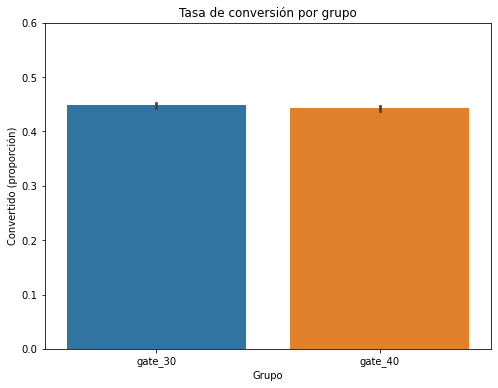

In [122]:
plt.figure(figsize = (8,6))

sns.barplot(x = unDia['version'], 
            y = unDia['retention_1'])

plt.ylim(0, 0.6)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

Las tasas de conversión para ambos grupos están muy cerca, pero MUY ligeramente, más alta la del grupo de control. Por lo que tanto, los jugadores volvieron a abrir la aplicación en ambos casos.

In [118]:
control = unDia[unDia.version == 'gate_30']['retention_1']
tratamiento = unDia[unDia.version == 'gate_40']['retention_1']

numControl = control.count()
numTratamiento = tratamiento.count()

conversiones = [control.sum(), tratamiento.sum()]

observaciones = [numControl, numTratamiento]

z_score, p_value = proportions_ztest(conversiones, nobs = observaciones)

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, nobs = observaciones, alpha = 0.05)

print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_value:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.78
p-valor: 0.074
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


In [119]:
tasas_conversion

,conversion_rate,std,std_error
version,,,
gate_30,0.448188,0.497308,0.002352
gate_40,0.442283,0.496658,0.002329


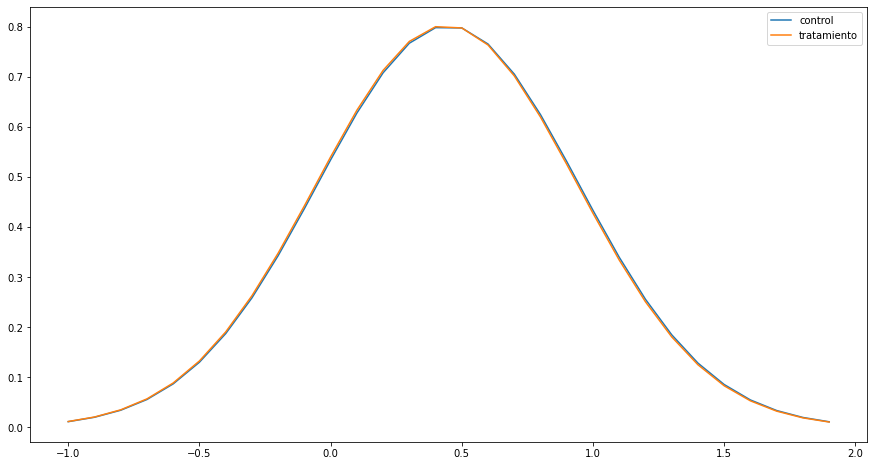

In [120]:
x = [i*.1 for i in range(-10, 20)]  

control = [norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento = [norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.rcParams['figure.figsize']=(15, 8)
plt.legend(['control', 'tratamiento']);


### TEST A LOS SIETE DÍAS

In [123]:
tasas_conversion = sieteDias.groupby('version')['retention_7']

std = lambda x: np.std(x, ddof = 0)
error_std = lambda x: stats.sem(x, ddof = 0)

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns = ['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


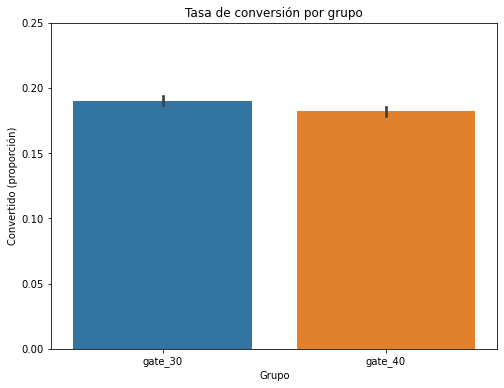

In [124]:
plt.figure(figsize = (8,6))

sns.barplot(x = sieteDias['version'], 
            y = sieteDias['retention_7'])

plt.ylim(0, 0.25)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

Las tasas de conversión para ambos grupos siguen muy cerca, pero es algo más alta la del grupo de control, esta vez es más apreciable.
El grupo de control es más probable que abra la aplicación después de 7 días de instalar el juego.

In [125]:
control = sieteDias[sieteDias.version == 'gate_30']['retention_7']
tratamiento = sieteDias[sieteDias.version == 'gate_40']['retention_7']

numControl = control.count()
numTratamiento = tratamiento.count()

conversiones = [control.sum(), tratamiento.sum()]

observaciones = [numControl, numTratamiento]

z_score, p_value = proportions_ztest(conversiones, nobs = observaciones)

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, nobs = observaciones, alpha = 0.05)

print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_value:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 3.16
p-valor: 0.002
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.178, 0.186]


In [126]:
tasas_conversion

,conversion_rate,std,std_error
version,,,
gate_30,0.190201,0.392460,0.001856
gate_40,0.182000,0.385845,0.001809


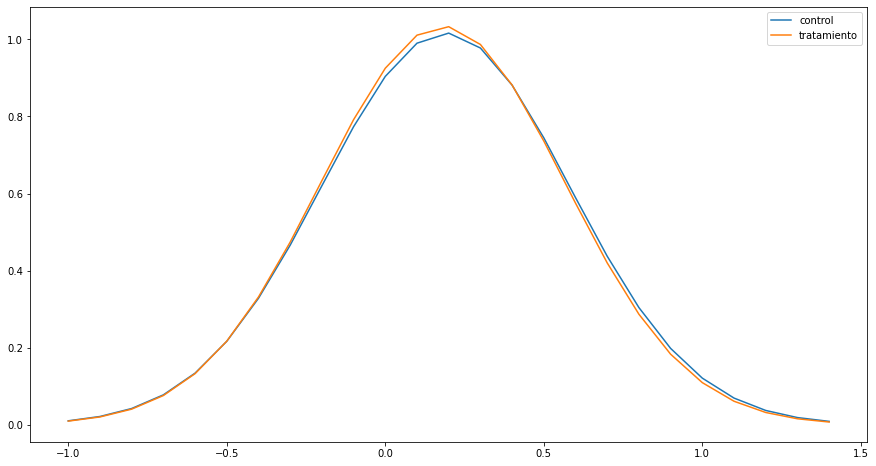

In [127]:
x = [i*.1 for i in range(-10, 15)]  

control = [norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento = [norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.rcParams['figure.figsize']=(15, 8)
plt.legend(['control', 'tratamiento']);

# AB TESTING BAYESIANO

### TEST DESPUÉS DE UN DÍA

In [173]:
control = unDia[unDia.version == 'gate_30']
tratamineto = unDia[unDia.version == 'gate_40']

imps_ctrl, convs_ctrl = len(control), len(control[control.retention_1 == True])
imps_test, convs_test = len(tratamineto), len(tratamineto[tratamineto.retention_1 == True])


CR_ctrl = convs_ctrl / imps_ctrl
CR_test = convs_test / imps_test

f'TASAS: Control={CR_ctrl}, Tratamiento={CR_test}'

'TASAS: Control=0.4481879194630872, Tratamiento=0.44228274967574577'

In [174]:
a_C, b_C = convs_ctrl + 1, imps_ctrl - convs_ctrl + 1
a_T, b_T = convs_test + 1, imps_test - convs_test + 1

beta_control = beta(a_C, b_C)
beta_test = beta(a_T, b_T)

In [175]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [176]:
x = np.linspace(0.43, 0.46, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y = bet.pdf(x)
        y_media = bet.mean()
        y_std = bet.std()
        
        plt.plot(x, y, label = '{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();
    plt.rcParams['figure.figsize']=(15, 8)

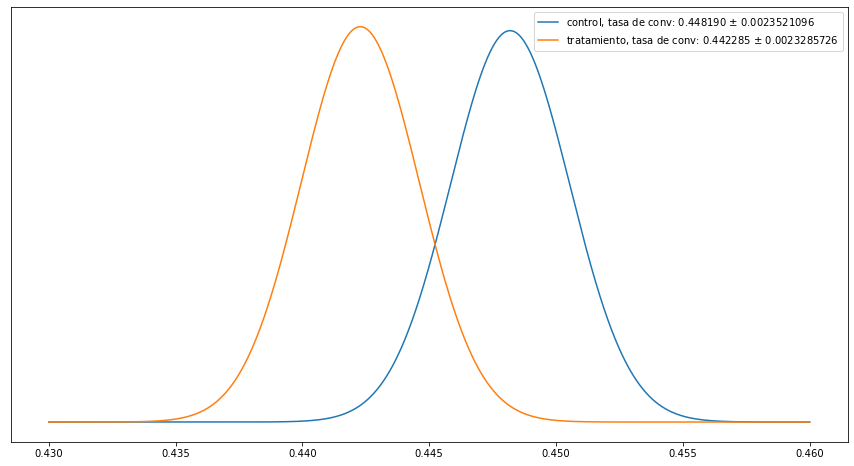

In [177]:
plot([beta_control, beta_test], ['control', 'tratamiento'])

In [178]:
salto = (beta_test.mean() - beta_control.mean()) / beta_control.mean()

salto

-0.013175098158249857

In [181]:
prob = 1 - beta_control.cdf(0.445)

In [182]:
'''El test disminuye la tasa de retención en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test disminuye la tasa de retención en un -1.32%, con una probabilidad del 91.25%'

### TEST DESPUÉS DE SIETE DÍAS

In [183]:
control = sieteDias[sieteDias.version == 'gate_30']
tratamineto = sieteDias[sieteDias.version == 'gate_40']

imps_ctrl, convs_ctrl = len(control), len(control[control.retention_7 == True])
imps_test, convs_test = len(tratamineto), len(tratamineto[tratamineto.retention_7 == True])


CR_ctrl = convs_ctrl / imps_ctrl
CR_test = convs_test / imps_test

f'TASAS: Control={CR_ctrl}, Tratamiento={CR_test}'

'TASAS: Control=0.19020134228187918, Tratamiento=0.18200004396667327'

In [264]:
a_C, b_C = convs_ctrl + 1, imps_ctrl - convs_ctrl + 1
a_T, b_T = convs_test + 1, imps_test - convs_test + 1

beta_control = beta(a_C, b_C)
beta_test = beta(a_T, b_T)

In [265]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [266]:
x = np.linspace(0.17, 0.2, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y = bet.pdf(x)
        y_media = bet.mean()
        y_std = bet.std()
        
        plt.plot(x, y, label = '{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();
    plt.rcParams['figure.figsize']=(15, 8)

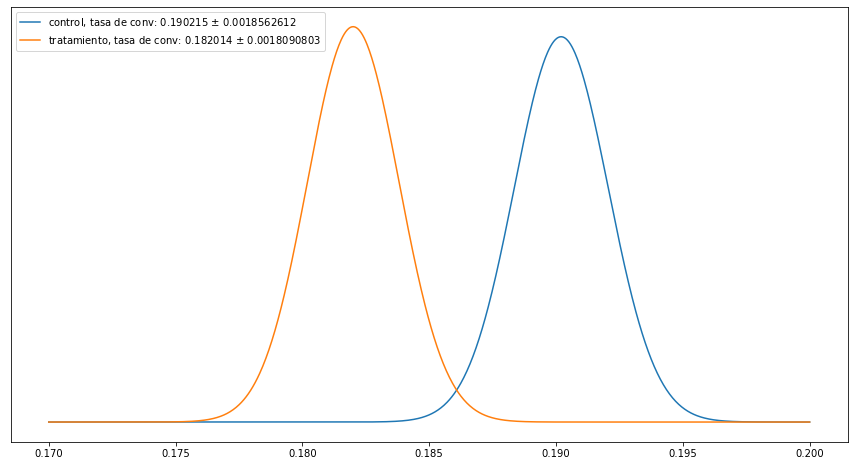

In [267]:
plot([beta_control, beta_test], ['control', 'tratamiento'])

In [276]:
salto = (beta_test.mean() - beta_control.mean()) / beta_control.mean()

salto

-0.04311526114658881

In [281]:
prob = 1 - beta_control.cdf(0.186)

In [282]:
'''El test disminuye la tasa de retención en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test disminuye la tasa de retención en un -4.31%, con una probabilidad del 98.87%'

## CONCLUSIÓN

En ambos tests, nos sale un porcentaje de tasa de retención negativa en un alto porcentaje de probabilidad. Por lo que, a priori, no nos interesaría cambiar a la puerta 40 para la retención. Se obtienen mejores resultados dejando la retención en la puerta 30.